<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mstats

# tensorflow for nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

# Plotting Function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Scorer Functions
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return sensitivity

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return specificity

def auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)
auroc_scorer = make_scorer(auroc_scorer)
aucpr_scorer = make_scorer(aucpr_scorer)

# Winsorization Class
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower=0.01, upper=0.99):
        self.columns = columns
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        # Keine spezielle Anpassung erforderlich
        return self

    def transform(self, X):
        if self.columns is None:
            columns = X.columns
        else:
            columns = self.columns

        X_copy = X.copy()
        for col in columns:
            X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])

        return X_copy

In [2]:
# !wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('unfinished_data.csv')
data.shape

(780, 52)

In [74]:
# Features
demographic = ['Age', 'Sex', 'Height', 'Weight', 'BMI', 'Length_of_Stay']

scoring = ['Alvarado_Score', 'Paedriatic_Appendicitis_Score']

clinical = ['Peritonitis', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
            'Ipsilateral_Rebound_Tenderness', 'Coughing_Pain', 'Psoas_Sign', 'Nausea', 'Loss_of_Appetite',
            'Body_Temperature', 'Dysuria', 'Stool']

laboratory = ['WBC_Count', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 
             'Neutrophil_Percentage', 'Neutrophilia', 'Segmented_Neutrophils', 
             'CRP', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine']

ultrasound = ['US_Performed', 'Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids','Appendix_Wall_Layers', 
              'Target_Sign', 'Perfusion', 'Surrounding_Tissue_Reaction','Pathological_Lymph_Nodes', 
              'Lymph_Node_Location', 'Bowel_Wall_Thickening', 'Ileus', 'Coprostasis', 'Meteorism', 
              'Enteritis', 'Apendicolith', 'Perforation', 'Appendicular_Abscess', 'Abscess_Location', 
              'Conglomerate_of_Bowel_Loops', 'Gynecological_Findings']

continuous = [
    "Age",
    "Height",
    "Weight",
    "BMI",
    "Length_of_Stay",
    "Body_Temperature",
    "WBC_Count",
    "RBC_Count",
    "Hemoglobin",
    "RDW",
    "Thrombocyte_Count",
    "Neutrophil_Percentage",
    "Segmented_Neutrophils",
    "CRP",
    "Appendix_Diameter"
]

'''
extreme_outlier = [
    "BMI",
    "Body_Temperature"
]
'''

FEATURES = [
    'Appendix_Diameter', 
    'Length_of_Stay', 
    'Surrounding_Tissue_Reaction', 
    'Alvarado_Score', 
    'Neutrophil_Percentage',
    'Appendix_on_US',
    'CRP',
    'Peritonitis',
    'WBC_Count'
]

TARGET = "Diagnosis"

In [75]:
# X = data.drop('Diagnosis', axis=1)  # Features
# y = data['Diagnosis']               # Target variable

X = data[FEATURES]
y = data[TARGET]

X.shape, y.shape

((780, 9), (780,))

In [76]:
# Results storage for confusion matrices, classification reports, and ROC curves
models = []
accuracy = []
accuracy_sd = []
sensitivity_list = []
sensitivity_sd = []
specificity_list = []
specificity_sd = []
auroc = []
auroc_sd = []
aucpr = []
aucpr_sd = []

confusion_matrices = []
roc_curves = []

## Logistic Regression

10-fold CV:
Accuracy: 	 0.879 (± 0.04 )
ROC: 	 	 0.881 (± 0.04 )
AUCPR: 	 	 0.877 (± 0.05 )
Sensitivy: 	 0.875 (± 0.05 )
Specificity: 	 0.887 (± 0.0 )
 


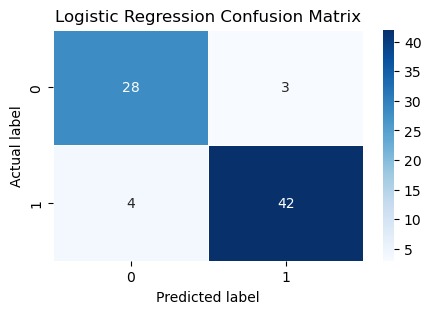

In [78]:
# Model & pipeline
lr_model = LogisticRegression(max_iter=1000, random_state=123)

lr_pipeline = Pipeline([
    # ('winsorizer', Winsorizer(columns=extreme_outlier)),
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', lr_model)
])

models.append('Logistic Regression')

# 10 fold CV
splits = 10
k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

# Calculate Scores
# Confusion Matrix
y_pred_cv = cross_val_predict(lr_pipeline, X, y, cv=k_fold)
cm_lr = confusion_matrix(y, y_pred_cv)
cm_lr = cm_lr / splits
cm_lr = np.round(cm_lr,0)
cm_lr = cm_lr.astype(int)
confusion_matrices.append(cm_lr)

# Accuracy
cv_scores_accuracy = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
sd_cv_accuracy = cv_scores_accuracy.std()
accuracy.append(mean_cv_accuracy)
accuracy_sd.append(sd_cv_accuracy)

# ROC
cv_scores_auroc = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring=auroc_scorer)
mean_cv_auroc = cv_scores_auroc.mean()
sd_cv_auroc = cv_scores_auroc.std()
auroc.append(mean_cv_auroc)
auroc_sd.append(sd_cv_auroc)

# AUCPR
cv_scores_aucpr = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring=aucpr_scorer)
mean_cv_aucpr = cv_scores_aucpr.mean()
sd_cv_aucpr = cv_scores_aucpr.std()
aucpr.append(mean_cv_aucpr)
aucpr_sd.append(sd_cv_aucpr)

# Sensitivy
cv_scores_sensitivity = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_sensitivity = cv_scores_sensitivity.mean()
sd_cv_sensitivity = cv_scores_sensitivity.std()
sensitivity_list.append(mean_cv_sensitivity)
sensitivity_sd.append(sd_cv_sensitivity)

# Specificity
cv_scores_specificity = cross_val_score(lr_pipeline, X_train, y_train, cv=k_fold, scoring=specificity_scorer)
mean_cv_specificity = cv_scores_specificity.mean()
sd_cv_specificity = mean_cv_specificity.std()
specificity_list.append(mean_cv_specificity)
specificity_sd.append(sd_cv_specificity)

# Calculate ROC curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
# roc_curves.append((fpr_lr, tpr_lr))

print("10-fold CV:")
print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
print(" ")
plot_confusion_matrix(cm_lr, "Logistic Regression Confusion Matrix")

## Naive Bayes Classifier

10-fold CV:
Accuracy: 	 0.645 (± 0.05 )
ROC: 	 	 0.697 (± 0.04 )
AUCPR: 	 	 0.748 (± 0.05 )
Sensitivy: 	 0.426 (± 0.07 )
Specificity: 	 0.968 (± 0.0 )
 


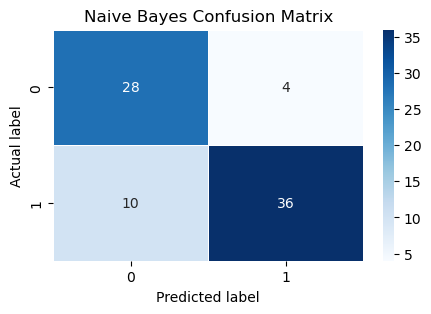

In [79]:
# Model & pipeline
nb_model = GaussianNB()

nb_pipeline = Pipeline([
    # ('winsorizer', Winsorizer(columns=extreme_outlier)),
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', nb_model)
])

models.append('Naive Bayes')

# 10 fold CV
splits = 10
k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

# Calculate Scores
# Confusion Matrix
y_pred_cv = cross_val_predict(nb_pipeline, X, y, cv=k_fold)
cm_nb = confusion_matrix(y, y_pred_cv)
cm_nb = cm_nb / splits
cm_nb = np.round(cm_nb,0)
cm_nb = cm_nb.astype(int)
confusion_matrices.append(cm_nb)

# Accuracy
cv_scores_accuracy = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
sd_cv_accuracy = cv_scores_accuracy.std()
accuracy.append(mean_cv_accuracy)
accuracy_sd.append(sd_cv_accuracy)

# ROC
cv_scores_auroc = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring=auroc_scorer)
mean_cv_auroc = cv_scores_auroc.mean()
sd_cv_auroc = cv_scores_auroc.std()
auroc.append(mean_cv_auroc)
auroc_sd.append(sd_cv_auroc)

# AUCPR
cv_scores_aucpr = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring=aucpr_scorer)
mean_cv_aucpr = cv_scores_aucpr.mean()
sd_cv_aucpr = cv_scores_aucpr.std()
aucpr.append(mean_cv_aucpr)
aucpr_sd.append(sd_cv_aucpr)

# Sensitivy
cv_scores_sensitivity = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_sensitivity = cv_scores_sensitivity.mean()
sd_cv_sensitivity = cv_scores_sensitivity.std()
sensitivity_list.append(mean_cv_sensitivity)
sensitivity_sd.append(sd_cv_sensitivity)

# Specificity
cv_scores_specificity = cross_val_score(nb_pipeline, X_train, y_train, cv=k_fold, scoring=specificity_scorer)
mean_cv_specificity = cv_scores_specificity.mean()
sd_cv_specificity = mean_cv_specificity.std()
specificity_list.append(mean_cv_specificity)
specificity_sd.append(sd_cv_specificity)

# Calculate ROC curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
# roc_curves.append((fpr_lr, tpr_lr))

print("10-fold CV:")
print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
print(" ")
plot_confusion_matrix(cm_nb, "Naive Bayes Confusion Matrix")

## Support Vector Machine

10-fold CV:
Accuracy: 	 0.873 (± 0.05 )
ROC: 	 	 0.871 (± 0.05 )
AUCPR: 	 	 0.867 (± 0.04 )
Sensitivy: 	 0.884 (± 0.07 )
Specificity: 	 0.859 (± 0.0 )
 


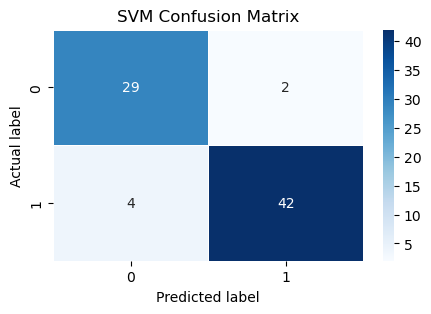

In [80]:
# Model & pipeline
svm_model = SVC(kernel='rbf', random_state=123, probability=True)

svm_pipeline = Pipeline([
    # ('winsorizer', Winsorizer(columns=extreme_outlier)),
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', svm_model)
])

models.append('SVM')

# 10 fold CV
splits = 10
k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

# Calculate Scores
# Confusion Matrix
y_pred_cv = cross_val_predict(svm_pipeline, X, y, cv=k_fold)
cm_svm = confusion_matrix(y, y_pred_cv)
cm_svm = cm_svm / splits
cm_svm = np.round(cm_svm,0)
cm_svm = cm_svm.astype(int)
confusion_matrices.append(cm_svm)

# Accuracy
cv_scores_accuracy = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
sd_cv_accuracy = cv_scores_accuracy.std()
accuracy.append(mean_cv_accuracy)
accuracy_sd.append(sd_cv_accuracy)

# ROC
cv_scores_auroc = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring=auroc_scorer)
mean_cv_auroc = cv_scores_auroc.mean()
sd_cv_auroc = cv_scores_auroc.std()
auroc.append(mean_cv_auroc)
auroc_sd.append(sd_cv_auroc)

# AUCPR
cv_scores_aucpr = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring=aucpr_scorer)
mean_cv_aucpr = cv_scores_aucpr.mean()
sd_cv_aucpr = cv_scores_aucpr.std()
aucpr.append(mean_cv_aucpr)
aucpr_sd.append(sd_cv_aucpr)

# Sensitivy
cv_scores_sensitivity = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_sensitivity = cv_scores_sensitivity.mean()
sd_cv_sensitivity = cv_scores_sensitivity.std()
sensitivity_list.append(mean_cv_sensitivity)
sensitivity_sd.append(sd_cv_sensitivity)

# Specificity
cv_scores_specificity = cross_val_score(svm_pipeline, X_train, y_train, cv=k_fold, scoring=specificity_scorer)
mean_cv_specificity = cv_scores_specificity.mean()
sd_cv_specificity = mean_cv_specificity.std()
specificity_list.append(mean_cv_specificity)
specificity_sd.append(sd_cv_specificity)

# Calculate ROC curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
# roc_curves.append((fpr_lr, tpr_lr))

print("10-fold CV:")
print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
print(" ")
plot_confusion_matrix(cm_svm, "SVM Confusion Matrix")

## Random Forest Classifier

10-fold CV:
Accuracy: 	 0.933 (± 0.03 )
ROC: 	 	 0.934 (± 0.03 )
AUCPR: 	 	 0.93 (± 0.03 )
Sensitivy: 	 0.934 (± 0.03 )
Specificity: 	 0.933 (± 0.0 )
 


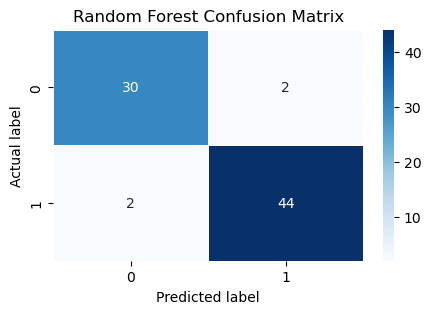

In [81]:
# Model & pipeline
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)

rf_pipeline = Pipeline([
    # ('winsorizer', Winsorizer(columns=extreme_outlier)),
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', rf_model)
])

models.append('Random Forest')

# 10 fold CV
splits = 10
k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

# Calculate Scores
# Confusion Matrix
y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=k_fold)
cm_rf = confusion_matrix(y, y_pred_cv)
cm_rf = cm_rf / splits
cm_rf = np.round(cm_rf,0)
cm_rf = cm_rf.astype(int)
confusion_matrices.append(cm_rf)

# Accuracy
cv_scores_accuracy = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
sd_cv_accuracy = cv_scores_accuracy.std()
accuracy.append(mean_cv_accuracy)
accuracy_sd.append(sd_cv_accuracy)

# ROC
cv_scores_auroc = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring=auroc_scorer)
mean_cv_auroc = cv_scores_auroc.mean()
sd_cv_auroc = cv_scores_auroc.std()
auroc.append(mean_cv_auroc)
auroc_sd.append(sd_cv_auroc)

# AUCPR
cv_scores_aucpr = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring=aucpr_scorer)
mean_cv_aucpr = cv_scores_aucpr.mean()
sd_cv_aucpr = cv_scores_aucpr.std()
aucpr.append(mean_cv_aucpr)
aucpr_sd.append(sd_cv_aucpr)

# Sensitivy
cv_scores_sensitivity = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_sensitivity = cv_scores_sensitivity.mean()
sd_cv_sensitivity = cv_scores_sensitivity.std()
sensitivity_list.append(mean_cv_sensitivity)
sensitivity_sd.append(sd_cv_sensitivity)

# Specificity
cv_scores_specificity = cross_val_score(rf_pipeline, X_train, y_train, cv=k_fold, scoring=specificity_scorer)
mean_cv_specificity = cv_scores_specificity.mean()
sd_cv_specificity = mean_cv_specificity.std()
specificity_list.append(mean_cv_specificity)
specificity_sd.append(sd_cv_specificity)

# Calculate ROC curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
# roc_curves.append((fpr_lr, tpr_lr))

print("10-fold CV:")
print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
print(" ")
plot_confusion_matrix(cm_rf, "Random Forest Confusion Matrix")

## Gradient Boosting Classifier

10-fold CV:
Accuracy: 	 0.944 (± 0.03 )
ROC: 	 	 0.944 (± 0.03 )
AUCPR: 	 	 0.94 (± 0.03 )
Sensitivy: 	 0.948 (± 0.03 )
Specificity: 	 0.94 (± 0.0 )
 


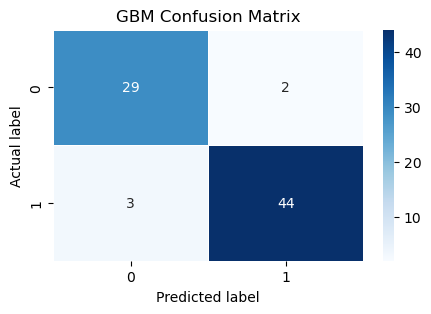

In [82]:
# Model & pipeline
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=123)

gbm_pipeline = Pipeline([
    # ('winsorizer', Winsorizer(columns=extreme_outlier)),
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5)),
    ('classifier', gbm_model)
])

models.append('GBM')

# 10 fold CV
splits = 10
k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

# Calculate Scores
# Confusion Matrix
y_pred_cv = cross_val_predict(gbm_pipeline, X, y, cv=k_fold)
cm_gbm = confusion_matrix(y, y_pred_cv)
cm_gbm = cm_gbm / splits
cm_gbm = np.round(cm_gbm,0)
cm_gbm = cm_gbm.astype(int)
confusion_matrices.append(cm_gbm)

# Accuracy
cv_scores_accuracy = cross_val_score(gbm_pipeline, X_train, y_train, cv=k_fold, scoring="accuracy")
mean_cv_accuracy = cv_scores_accuracy.mean()
sd_cv_accuracy = cv_scores_accuracy.std()
accuracy.append(mean_cv_accuracy)
accuracy_sd.append(sd_cv_accuracy)

# ROC
cv_scores_auroc = cross_val_score(gbm_pipeline, X_train, y_train, cv=k_fold, scoring=auroc_scorer)
mean_cv_auroc = cv_scores_auroc.mean()
sd_cv_auroc = cv_scores_auroc.std()
auroc.append(mean_cv_auroc)
auroc_sd.append(sd_cv_auroc)

# AUCPR
cv_scores_aucpr = cross_val_score(gbm_pipeline, X_train, y_train, cv=k_fold, scoring=aucpr_scorer)
mean_cv_aucpr = cv_scores_aucpr.mean()
sd_cv_aucpr = cv_scores_aucpr.std()
aucpr.append(mean_cv_aucpr)
aucpr_sd.append(sd_cv_aucpr)

# Sensitivy
cv_scores_sensitivity = cross_val_score(gbm_pipeline, X_train, y_train, cv=k_fold, scoring="recall")
mean_cv_sensitivity = cv_scores_sensitivity.mean()
sd_cv_sensitivity = cv_scores_sensitivity.std()
sensitivity_list.append(mean_cv_sensitivity)
sensitivity_sd.append(sd_cv_sensitivity)

# Specificity
cv_scores_specificity = cross_val_score(gbm_pipeline, X_train, y_train, cv=k_fold, scoring=specificity_scorer)
mean_cv_specificity = cv_scores_specificity.mean()
sd_cv_specificity = mean_cv_specificity.std()
specificity_list.append(mean_cv_specificity)
specificity_sd.append(sd_cv_specificity)

# Calculate ROC curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
# roc_curves.append((fpr_lr, tpr_lr))

print("10-fold CV:")
print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
print(" ")
plot_confusion_matrix(cm_gbm, "GBM Confusion Matrix")

## Neural Network

In [92]:
# Pipeline                      
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('imputer', KNNImputer(n_neighbors=5))
])
                        
models.append('Neural Network')

# Transform the data
X_train_prepared = nn_pipeline.fit_transform(X_train)
X_test_prepared = nn_pipeline.transform(X_test)

# Build a simple neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_prepared.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid because of binaray classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to record training metrics
class MetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy.append(logs['accuracy'])

# Fit the neural network
history = model.fit(X_train_prepared, y_train, epochs=50, validation_split=0.1)

# Evaluate the model on the test set
loss, test_accuracy = model.evaluate(X_test_prepared, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Update your metrics list with neural network performance
accuracy.append(test_accuracy)  # Append test accuracy for NN

# Retrieve the confusion matrix and ROC curve from the neural network's predictions
y_pred_nn = (model.predict(X_test_prepared) > 0.5).astype("int32")
cm_nn = confusion_matrix(y_test, y_pred_nn)
confusion_matrices.append(cm_nn)

# Calculate ROC curve data and AUC for neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, model.predict(X_test_prepared).ravel())
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_curves.append((fpr_nn, tpr_nn))  # Store ROC curve data correctly

# Calculate precision, recall, and F1 score from confusion matrix
nn_recall = recall_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)

# Append calculated metrics to their respective lists
precision.append(nn_precision)
recall.append(nn_recall)
f1.append(nn_f1)

# Calculate additional rates
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn).ravel()
nn_true_positive_rate = tp / (tp + fn)
nn_false_positive_rate = fp / (fp + tn)
nn_true_negative_rate = tn / (tn + fp)
nn_false_negative_rate = fn / (fn + tp)

tpr.append(nn_true_positive_rate)
fpr.append(nn_false_positive_rate)
tnr.append(nn_true_negative_rate)
fnr.append(nn_false_negative_rate)

# Print metrics for confirmation
print(" ")
print("Neural Network Metrics:")
print("Accuracy: \t", round(test_accuracy, 3))
print("Recall:", round(nn_recall, 4))
print("F1 Score:", round(nn_f1, 4))
print(" ")
print("True Positive Rate:", round(nn_true_positive_rate, 4))
print("False Positive Rate:", round(nn_false_positive_rate, 4))
print("True Negative Rate:", round(nn_true_negative_rate, 4))
print("False Negative Rate:", round(nn_false_negative_rate, 4))

Epoch 1/50


C:\Users\mariu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5950 - loss: 0.6534 - val_accuracy: 0.7746 - val_loss: 0.4695
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7915 - loss: 0.4376 - val_accuracy: 0.7746 - val_loss: 0.3906
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8618 - loss: 0.3405 - val_accuracy: 0.8451 - val_loss: 0.3330
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9113 - loss: 0.2642 - val_accuracy: 0.9014 - val_loss: 0.2951
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.2250 - val_accuracy: 0.9014 - val_loss: 0.2773
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9249 - loss: 0.2061 - val_accuracy: 0.9014 - val_loss: 0.2574
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9596 - loss: 0.1362 - val_accuracy: 0.9155 - val_loss: 0.2531
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9587 - loss: 0.1372 - val_accuracy: 0.9296 - val_loss: 0.2437
Ep

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FFE9140A40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


NameError: name 'precision' is not defined

## Summary & Model Comparison

In [40]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["Accuracy", "ROC", "AUCPR"]
values = [accuracy, roc, aucpr]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Performance Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'roc' is not defined

In [13]:
colors = sns.color_palette("coolwarm", len(models))

metrics = ["TP-Rate", "FP-Rate", "TN-Rate", "FN-Rate"]
values = [tpr, fpr, tnr, fnr]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    data[metric] = metric_values
metrics_df = pd.DataFrame(data)

metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Rates Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'tpr' is not defined

## AUC, ROC

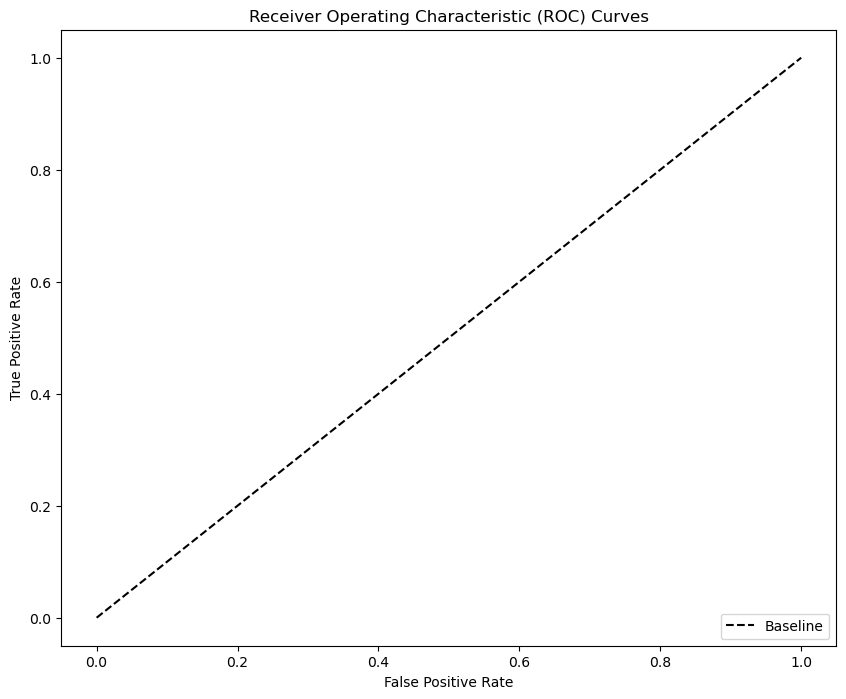

In [47]:
# Set up the figure
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Plot each model's ROC curve
for (fpr, tpr), model_name in zip(roc_curves, models):
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {model_auc:.2f})')

plt.legend(loc='lower right')
plt.show()